In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Reshape, LeakyReLU, BatchNormalization, Conv2D, Conv2DTranspose, Dropout, Input, concatenate, ReLU, Add
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

from zipfile import ZipFile, ZIP_DEFLATED

In [3]:
print("Total GPU available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Total GPU available:  1


In [4]:
# Constants
INPUT_DIR = '/kaggle/input/gan-getting-started'
INPUT_MONET_JPG_DIR = '/kaggle/input/gan-getting-started/monet_jpg'
INPUT_PHOTO_JPG_DIR = '/kaggle/input/gan-getting-started/photo_jpg'

# Dataset Description

The input folder contains two set of folders and same images in jpg and tfrec formats.  I am using TFREC format as it is efficient to use.

## Helper functions for Dataset Handling

In [5]:
# Function to load and preprocess an image
def load_and_preprocess_image(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [256, 256])
    image = (image / 127.5) - 1  # Normalize to [-1, 1]
    return image

# Create datasets from file paths
def load_dataset(file_paths):
    dataset = tf.data.Dataset.from_tensor_slices(file_paths)
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(1).repeat()
    return dataset

## EDA

In [6]:
# Load the image file paths
monet_files = tf.io.gfile.glob(f'{INPUT_MONET_JPG_DIR}/*.jpg')
photo_files = tf.io.gfile.glob(f'{INPUT_PHOTO_JPG_DIR}/*.jpg')

# Print the number of image files
print(f"Number of Monet image files: {len(monet_files)}")
print(f"Number of photo image files: {len(photo_files)}")

Number of Monet image files: 300
Number of photo image files: 7038


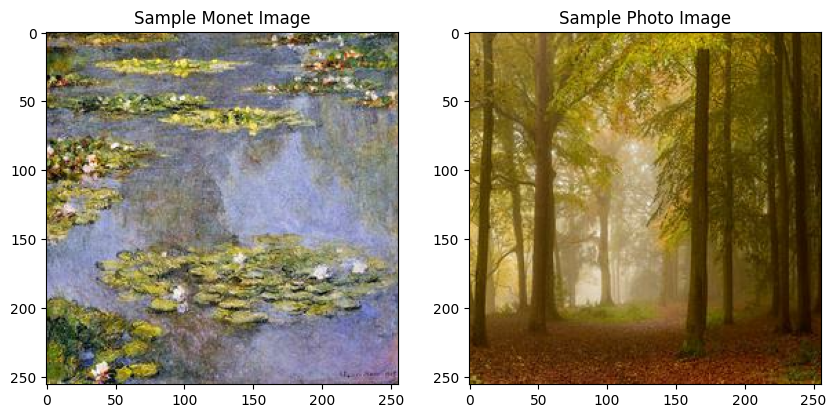

In [7]:
monet_dataset = load_dataset(monet_files)
photo_dataset = load_dataset(photo_files)

# Display a sample image from each dataset
sample_monet_image = load_and_preprocess_image(monet_files[0])
sample_photo_image = load_and_preprocess_image(photo_files[0])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Sample Monet Image")
plt.imshow((sample_monet_image + 1) / 2.0)  # Normalize to [0, 1] for display

plt.subplot(1, 2, 2)
plt.title("Sample Photo Image")
plt.imshow((sample_photo_image + 1) / 2.0)  # Normalize to [0, 1] for display

plt.show()

# Overview of GAN

The algorithm implemented here is a type of Generative Adversarial Network (GAN) specifically designed for image-to-image translation. The architecture is inspired by the Vennila GAN, which utilizes a U-Net based generator and a PatchGAN discriminator. This GAN is a Conditional GAN (cGAN) used for image-to-image translation. It is designed to convert input images (photos) into output images (Monet-style paintings).

## Components

### Generator (U-Net):

The generator is responsible for creating images. It takes an input image (a photo) and generates an output image (a Monet-style painting).

The U-Net architecture is used, which consists of an encoder (downsampling path) and a decoder (upsampling path) with skip connections between layers of equal resolution in the encoder and decoder.

The encoder progressively reduces the spatial dimensions of the image while increasing the number of feature maps, capturing the context of the image.

The decoder progressively increases the spatial dimensions while reducing the number of feature maps, reconstructing the image from the encoded context.

### Discriminator (PatchGAN):

The discriminator's role is to distinguish between real images (actual Monet paintings) and fake images (generated by the generator).

Instead of classifying the entire image, a PatchGAN classifier classifies 70x70 patches of the image, making it more effective at focusing on high-frequency local information.

This discriminator outputs a matrix of predictions, where each prediction corresponds to a patch of the image being real or fake.

### Loss Functions:

`Generator Loss:` The loss functions used here are
1. Adversarial Loss: Measures RSE value between discriminators reponse for generated image and real image
2. L1 Loss: Ensures that the generated image is similar to the input photo in terms of pixel values, which helps in maintaining the structure of the input image.

`Discriminator Loss:`
1. Real Loss: Measures how well the discriminator can classify real images as real.
2. Fake Loss: Measures how well the discriminator can classify fake images as fake.

# Model Design

In [8]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same',
                      kernel_initializer=initializer, use_bias=False))
    if apply_batchnorm:
        result.add(BatchNormalization())
    result.add(LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(Conv2DTranspose(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))
    result.add(BatchNormalization())
    if apply_dropout:
        result.add(Dropout(0.5))
    result.add(ReLU())
    return result

# Generator

In [9]:
def Generator():
    inputs = Input(shape=[256, 256, 3])
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]
    up_stack = [
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4, apply_dropout=True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4),
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(3, 4, strides=2, padding='same',
                           kernel_initializer=initializer, activation='tanh')
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concatenate([x, skip])
    x = last(x)
    return Model(inputs=inputs, outputs=x)

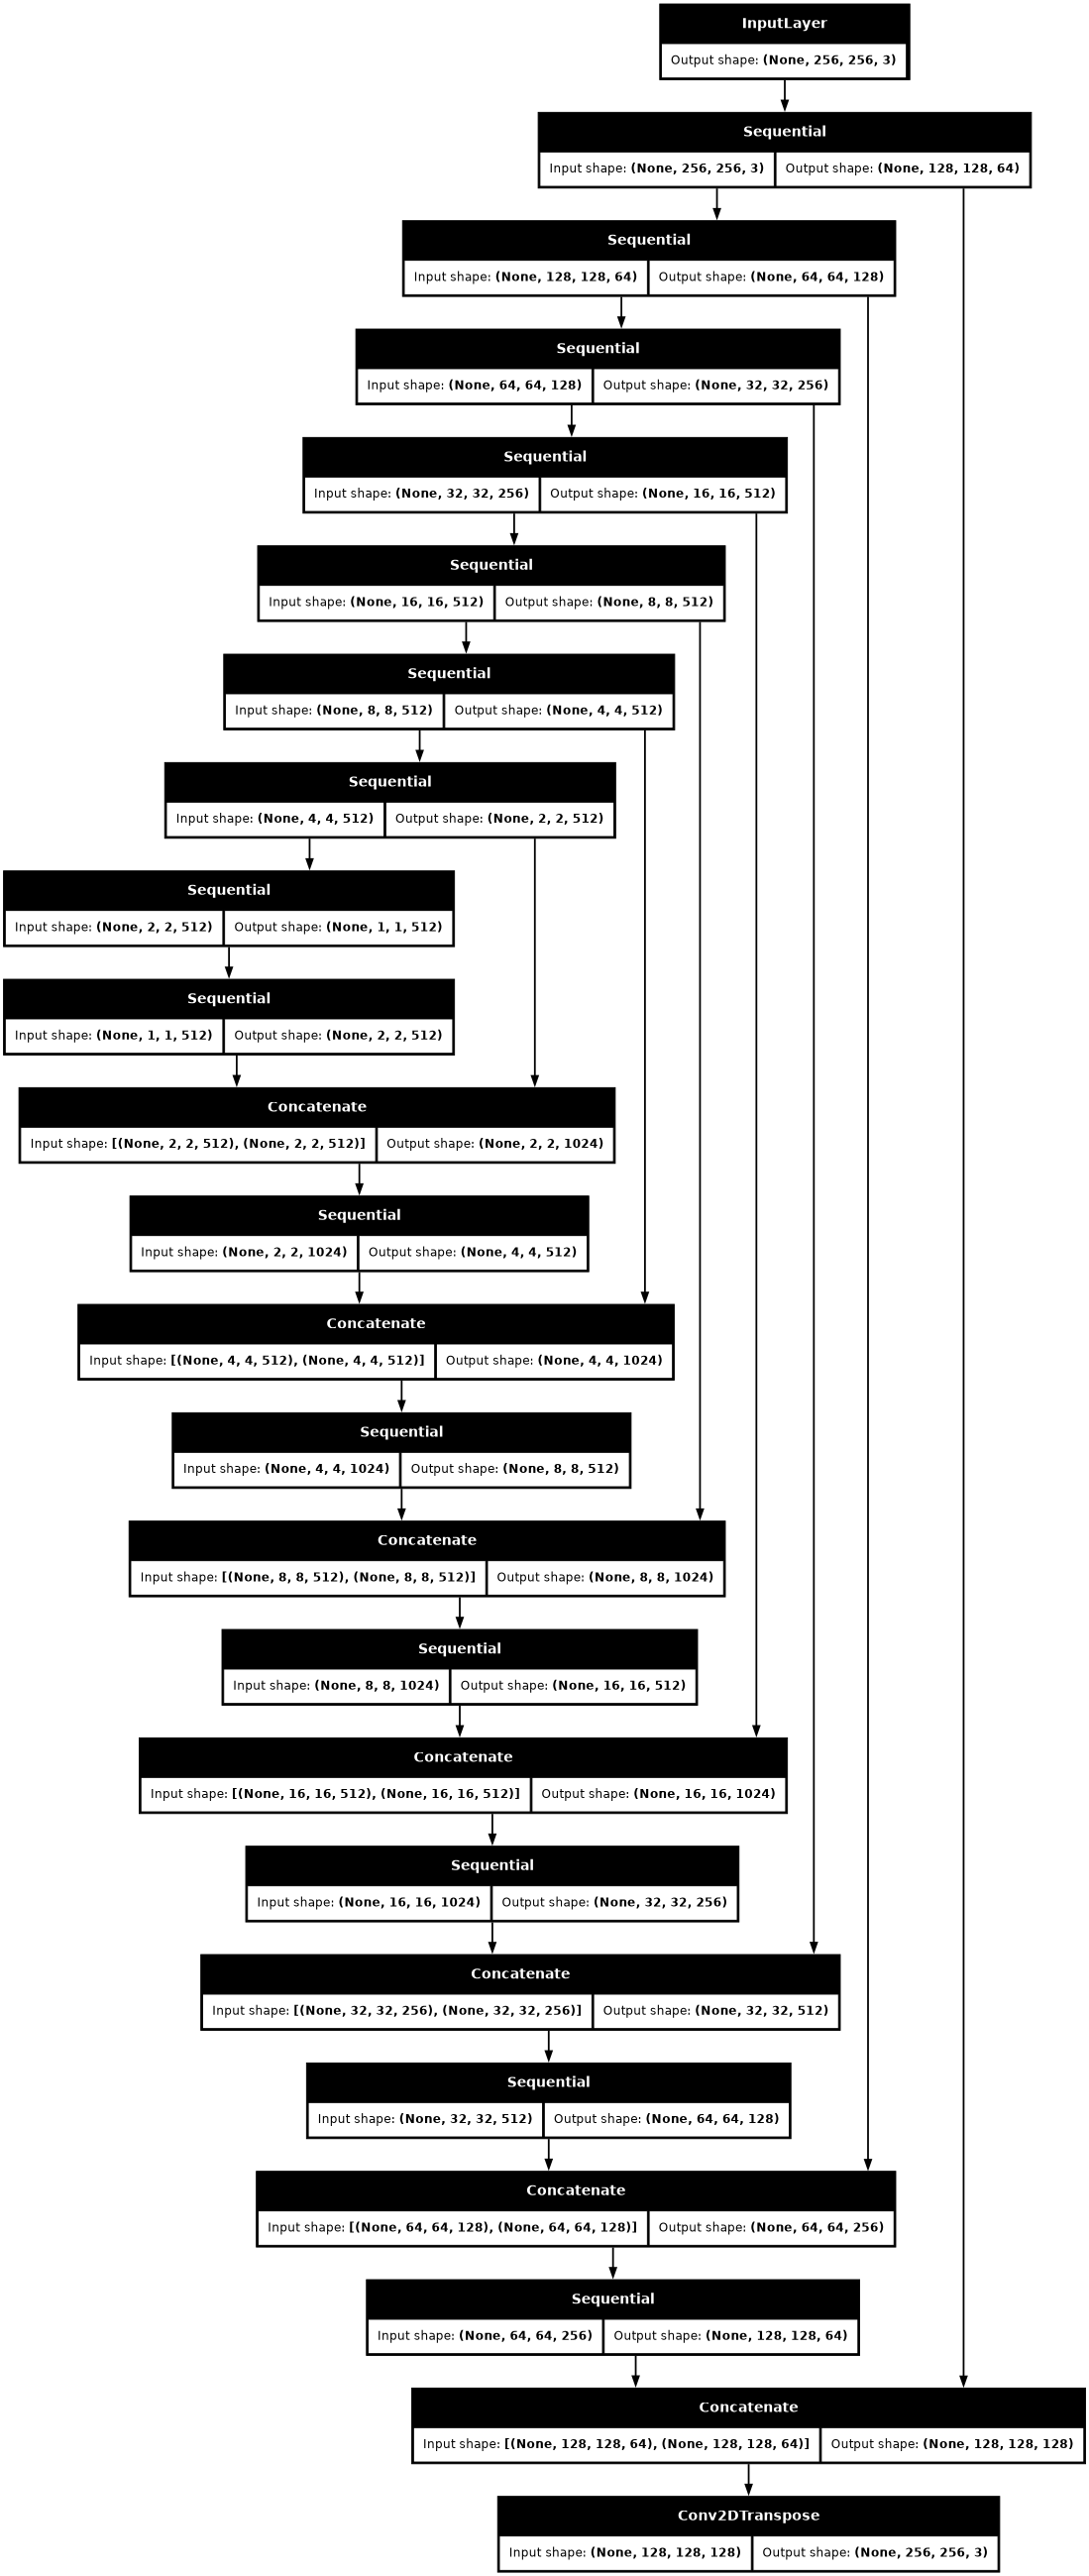

In [10]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

# Discriminator

In [11]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = Input(shape=[256, 256, 3], name='input_image')
    tar = Input(shape=[256, 256, 3], name='target_image')
    x = concatenate([inp, tar])
    down1 = downsample(64, 4, False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)
    down4 = downsample(512, 4)(down3)
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down4)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1)
    batchnorm1 = BatchNormalization()(conv)
    leaky_relu = LeakyReLU()(batchnorm1)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)
    return Model(inputs=[inp, tar], outputs=last)


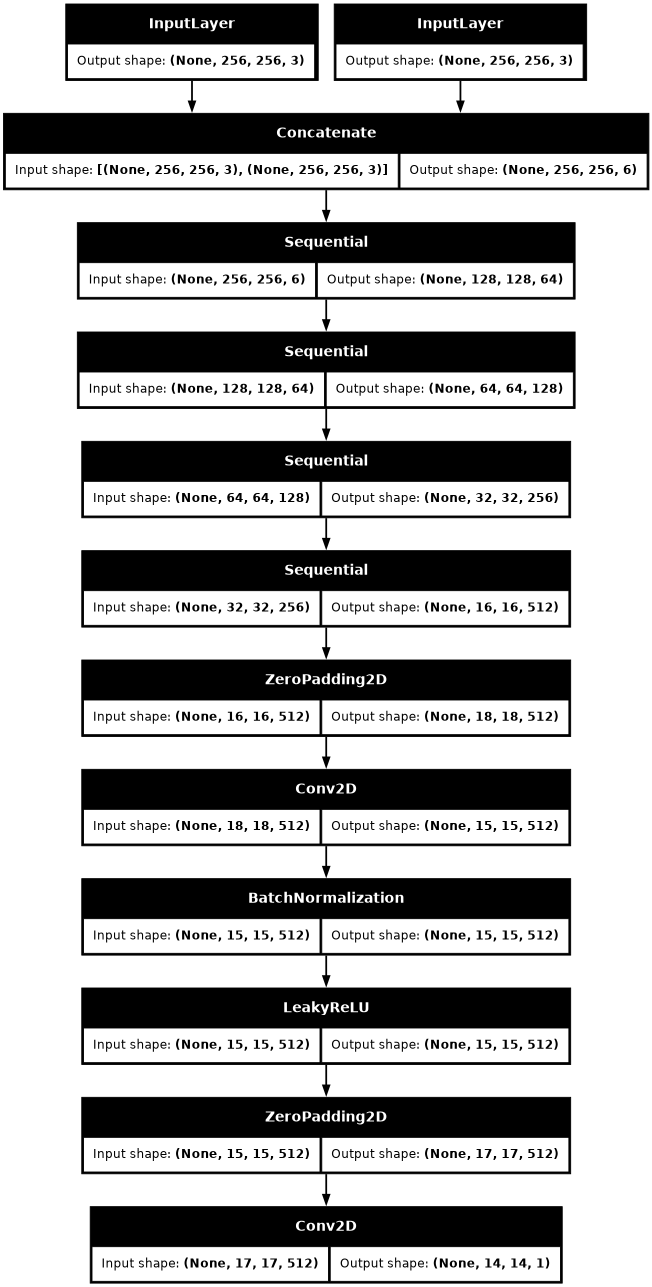

In [12]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

## GAN Model

In [13]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, gen_optimizer, disc_optimizer, gen_loss_fn, disc_loss_fn):
        super(GAN, self).compile()
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn

    def train_step(self, batch):
        real_images, target_images = batch
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(real_images, training=True)
            real_output = self.discriminator([real_images, target_images], training=True)
            generated_output = self.discriminator([real_images, generated_images], training=True)
            
            # Calculate generator and discriminator loss
            gen_loss = self.gen_loss_fn(disc_generated_output=generated_output, gen_output=generated_images, target=target_images)
            disc_loss = self.disc_loss_fn(disc_real_output=real_output, disc_generated_output=generated_output)

        # Calculate gradients and update the weights
        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        self.gen_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return {"gen_loss": gen_loss, "disc_loss": disc_loss}

# Loss functions
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Compile the GAN model
gan = GAN(generator, discriminator)
gan.compile(
    gen_optimizer=generator_optimizer,
    disc_optimizer=discriminator_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss
)


In [14]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, sample_interval, test_input, output_dir='generated_images'):
        self.sample_interval = sample_interval
        self.test_input = test_input
        self.output_dir = output_dir
        self.gen_losses = []
        self.disc_losses = []
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
    def on_epoch_end(self, epoch, logs=None):
        self.gen_losses.append(logs['gen_loss'])
        self.disc_losses.append(logs['disc_loss'])
        
        if epoch % self.sample_interval == 0:
            self.plot_losses()
            self.save_sample_images(epoch)
    
    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.gen_losses, label='Generator Loss')
        plt.plot(self.disc_losses, label='Discriminator Loss')
        plt.title('Losses over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(self.output_dir, 'losses.png'))
        plt.close()

    def save_sample_images(self, epoch):
        predictions = self.model.generator(self.test_input, training=False)
        for i in range(predictions.shape[0]):
            image = tf.image.convert_image_dtype(predictions[i], dtype=tf.uint8)
            image_path = os.path.join(self.output_dir, f'sample_{epoch}_{i}.jpg')
            tf.io.write_file(image_path, tf.image.encode_jpeg(image))

## Training Model

In [15]:
EPOCHS = 10
STEPS_PER_EPOCH = max(len(photo_files) // 1, 1)

# Prepare the datasets for training
monet_dataset = load_dataset(monet_files)
photo_dataset = load_dataset(photo_files)
dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset)).shuffle(buffer_size=1000)

# Callbacks for early stopping, learning rate reduction, and GAN monitoring
early_stopping = EarlyStopping(monitor='gen_loss', patience=10, verbose=1, restore_best_weights=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='gen_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode='min')
gan_monitor = GANMonitor(sample_interval=3, test_input=next(iter(photo_dataset.take(1))))

# Train the model with callbacks - Disabled to submit the model with CycleGAN
#gan.fit(dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[early_stopping, reduce_lr, gan_monitor])


In [16]:
# Generate final set of images
#generate_and_save_images(gan, num_images=7000, photo_dataset=photo_dataset)

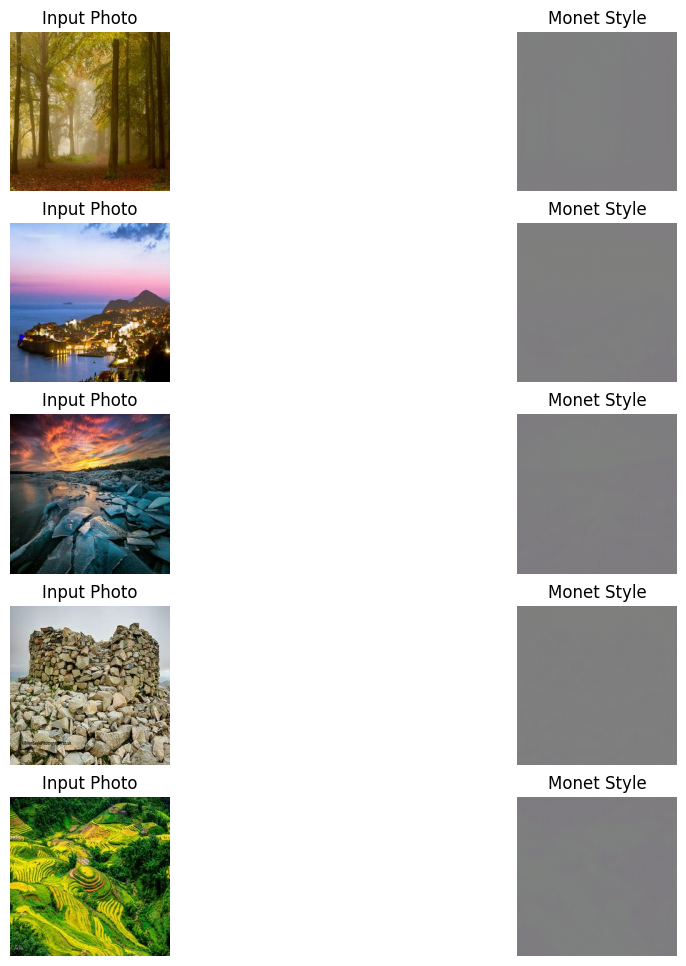

In [17]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet Style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

# CycleGAN

After the vanila GAN implementation, I wanted to experiment with CycleGAN, mainly based on Karas documentation.

The CycleGAN model is designed for unpaired image-to-image translation, meaning it can learn to translate images from one domain (e.g., photos) to another domain (e.g., Monet paintings) without needing paired examples.

## Components

### Generator:

Consists of convolutional layers for down-sampling, residual blocks for transformation, and transposed convolutional layers for up-sampling.

### Discriminator:

Uses convolutional layers with LeakyReLU activations to classify images as real or fake.

### Loss Functions:

`Discriminator Loss`: Measures how well the discriminator distinguishes real images from generated (fake) images.

`Generator Loss`: Measures how well the generator fools the discriminator.

`Cycle Consistency Loss`: Ensures that an image translated to the target domain and back to the original domain remains the same.

`Identity Loss`: Encourages the generator to preserve color composition between the input and output.

### Optimizers:

Adam optimizers with a learning rate of 2e-4 and beta1 of 0.5 are used for both generators and discriminators.

## Model Blocks

In [18]:
# Residual Block
def residual_block(x, filters, size=3):
    initializer = tf.random_normal_initializer(0., 0.02)
    x_shortcut = x

    x = Conv2D(filters, size, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(filters, size, strides=1, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)

    x = Add()([x, x_shortcut])
    return x

# Generator
def build_generator(num_residual_blocks):
    inputs = Input(shape=[256, 256, 3])
    initializer = tf.random_normal_initializer(0., 0.02)
    x = Conv2D(64, 7, padding='same', kernel_initializer=initializer, use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(128, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(256, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    for _ in range(num_residual_blocks):
        x = residual_block(x, 256)

    x = Conv2DTranspose(128, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2DTranspose(64, 3, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = Conv2D(3, 7, padding='same', kernel_initializer=initializer, activation='tanh')(x)

    return Model(inputs=inputs, outputs=x)

# Discriminator
def build_discriminator():
    inputs = Input(shape=[256, 256, 3])
    initializer = tf.random_normal_initializer(0., 0.02)

    x = Conv2D(64, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(inputs)
    x = LeakyReLU()(x)

    x = Conv2D(128, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(256, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(512, 4, strides=2, padding='same', kernel_initializer=initializer, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2D(1, 4, padding='same', kernel_initializer=initializer)(x)

    return Model(inputs=inputs, outputs=x)


## Loss Functions

In [33]:
# Define CycleGAN loss functions
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image, LAMBDA):
    return LAMBDA * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, LAMBDA):
    return LAMBDA * 0.5 * tf.reduce_mean(tf.abs(real_image - same_image))

class LossHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.gen_g_loss = []
        self.gen_f_loss = []
        self.disc_x_loss = []
        self.disc_y_loss = []

    def on_epoch_end(self, epoch, logs=None):
        self.gen_g_loss.append(logs['gen_g_loss'])
        self.gen_f_loss.append(logs['gen_f_loss'])
        self.disc_x_loss.append(logs['disc_x_loss'])
        self.disc_y_loss.append(logs['disc_y_loss'])

# Create optimizers for generators and discriminators
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


## CycleGAN Model

In [34]:
class CycleGAN(tf.keras.Model):
    def __init__(self, generator_g, generator_f, discriminator_x, discriminator_y, lambda_cycle=10):
        super(CycleGAN, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        self.lambda_cycle = lambda_cycle

    def compile(self, gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.gen_g_optimizer = gen_g_optimizer
        self.gen_f_optimizer = gen_f_optimizer
        self.disc_x_optimizer = disc_x_optimizer
        self.disc_y_optimizer = disc_y_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch):
        real_x, real_y = batch

        with tf.GradientTape(persistent=True) as tape:
            # Forward pass through the generators
            fake_y = self.generator_g(real_x, training=True)
            cycled_x = self.generator_f(fake_y, training=True)

            fake_x = self.generator_f(real_y, training=True)
            cycled_y = self.generator_g(fake_x, training=True)

            # Identity mapping
            same_y = self.generator_g(real_y, training=True)
            same_x = self.generator_f(real_x, training=True)

            # Discriminator outputs
            disc_real_x = self.discriminator_x(real_x, training=True)
            disc_real_y = self.discriminator_y(real_y, training=True)

            disc_fake_x = self.discriminator_x(fake_x, training=True)
            disc_fake_y = self.discriminator_y(fake_y, training=True)

            # Generator losses
            gen_g_loss = self.gen_loss_fn(disc_fake_y)
            gen_f_loss = self.gen_loss_fn(disc_fake_x)

            # Cycle losses
            total_cycle_loss = self.cycle_loss_fn(real_x, cycled_x, self.lambda_cycle) + self.cycle_loss_fn(real_y, cycled_y, self.lambda_cycle)

            # Identity losses
            total_identity_loss = self.identity_loss_fn(real_x, same_x, self.lambda_cycle) + self.identity_loss_fn(real_y, same_y, self.lambda_cycle)

            # Total generator losses
            total_gen_g_loss = gen_g_loss + total_cycle_loss + total_identity_loss
            total_gen_f_loss = gen_f_loss + total_cycle_loss + total_identity_loss

            # Discriminator losses
            disc_x_loss = self.disc_loss_fn(disc_real_x, disc_fake_x)
            disc_y_loss = self.disc_loss_fn(disc_real_y, disc_fake_y)

        # Calculate gradients and apply optimizers
        grads_g = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        grads_f = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        disc_x_grads = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        disc_y_grads = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)

        self.gen_g_optimizer.apply_gradients(zip(grads_g, self.generator_g.trainable_variables))
        self.gen_f_optimizer.apply_gradients(zip(grads_f, self.generator_f.trainable_variables))
        self.disc_x_optimizer.apply_gradients(zip(disc_x_grads, self.discriminator_x.trainable_variables))
        self.disc_y_optimizer.apply_gradients(zip(disc_y_grads, self.discriminator_y.trainable_variables))

        return {
            "gen_g_loss": total_gen_g_loss,
            "gen_f_loss": total_gen_f_loss,
            "disc_x_loss": disc_x_loss,
            "disc_y_loss": disc_y_loss,
        }


## Training

In [35]:
class CycleGANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, sample_interval, test_input, output_dir='cyclegan_generated_images'):
        self.sample_interval = sample_interval
        self.test_input = test_input
        self.output_dir = output_dir
        self.gen_g_losses = []
        self.gen_f_losses = []
        self.disc_x_losses = []
        self.disc_y_losses = []
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            
    def on_epoch_end(self, epoch, logs=None):
        self.gen_g_losses.append(logs['gen_g_loss'])
        self.gen_f_losses.append(logs['gen_f_loss'])
        self.disc_x_losses.append(logs['disc_x_loss'])
        self.disc_y_losses.append(logs['disc_y_loss'])
        
        if epoch % self.sample_interval == 0:
            self.plot_losses()
            self.save_sample_images(epoch)
    
    def plot_losses(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.gen_g_losses, label='Generator G Loss')
        plt.plot(self.gen_f_losses, label='Generator F Loss')
        plt.plot(self.disc_x_losses, label='Discriminator X Loss')
        plt.plot(self.disc_y_losses, label='Discriminator Y Loss')
        plt.title('Losses over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(self.output_dir, 'losses.png'))
        plt.close()

    def save_sample_images(self, epoch):
        fake_y = self.model.generator_g(self.test_input, training=False)
        for i in range(fake_y.shape[0]):
            image = tf.image.convert_image_dtype(fake_y[i], dtype=tf.uint8)
            image_path = os.path.join(self.output_dir, f'sample_{epoch}_{i}.jpg')
            tf.io.write_file(image_path, tf.image.encode_jpeg(image))


In [36]:
# Reducing input for testing
monet_files = tf.io.gfile.glob(f'{INPUT_MONET_JPG_DIR}/*.jpg')[:100]
photo_files = tf.io.gfile.glob(f'{INPUT_PHOTO_JPG_DIR}/*.jpg')[:100]

print(f"Number of Monet image files: {len(monet_files)}")
print(f"Number of photo image files: {len(photo_files)}")

Number of Monet image files: 100
Number of photo image files: 100


In [37]:
# Define the generators and discriminators
generator_g = build_generator(1)  # Photo to Monet
generator_f = build_generator(1)  # Monet to Photo
discriminator_x = build_discriminator()  # Discriminator for Monet
discriminator_y = build_discriminator()  # Discriminator for Photo

# Compile the CycleGAN model
cycle_gan = CycleGAN(generator_g, generator_f, discriminator_x, discriminator_y, lambda_cycle=10)

cycle_gan.compile(
    gen_g_optimizer=generator_g_optimizer,
    gen_f_optimizer=generator_f_optimizer,
    disc_x_optimizer=discriminator_x_optimizer,
    disc_y_optimizer=discriminator_y_optimizer,
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=cycle_loss,
    identity_loss_fn=identity_loss
)

# Callbacks for early stopping and learning rate reduction
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='gen_g_loss', patience=10, verbose=1, restore_best_weights=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='gen_g_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode='min')

loss_history = LossHistory()
gan_monitor = CycleGANMonitor(sample_interval=10, test_input=next(iter(photo_dataset.take(1))))

# Training the CycleGAN model
EPOCHS = 25
STEPS_PER_EPOCH = max(len(photo_files) // 1, 1)

# Prepare the datasets for training
monet_dataset = load_dataset(monet_files)
photo_dataset = load_dataset(photo_files)
dataset = tf.data.Dataset.zip((photo_dataset, monet_dataset)).shuffle(buffer_size=1000)

# Train the model with callbacks
cycle_gan.fit(dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[early_stopping, reduce_lr, loss_history])


Epoch 1/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 51s 141ms/step - disc_x_loss: 0.7164 - disc_y_loss: 0.7109 - gen_f_loss: 10.5826 - gen_g_loss: 10.5825 - learning_rate: 0.0010
Epoch 2/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - disc_x_loss: 0.6742 - disc_y_loss: 0.6727 - gen_f_loss: 8.9593 - gen_g_loss: 8.9665 - learning_rate: 0.0010
Epoch 3/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - disc_x_loss: 0.6789 - disc_y_loss: 0.6567 - gen_f_loss: 8.6481 - gen_g_loss: 8.7059 - learning_rate: 0.0010
Epoch 4/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - disc_x_loss: 0.6581 - disc_y_loss: 0.6549 - gen_f_loss: 8.8295 - gen_g_loss: 8.8592 - learning_rate: 0.0010
Epoch 5/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - disc_x_loss: 0.6318 - disc_y_loss: 0.6272 - gen_f_loss: 8.0656 - gen_g_loss: 8.0683 - learning_rate: 0.0010
Epoch 6/25
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - disc_x_loss: 0.6345 - disc_y_loss: 0.6262 - gen_f_loss: 8.2702 - gen_g_loss: 8.3010 - learning_rate: 0.0010
Epoch 7/

## Loss Plot

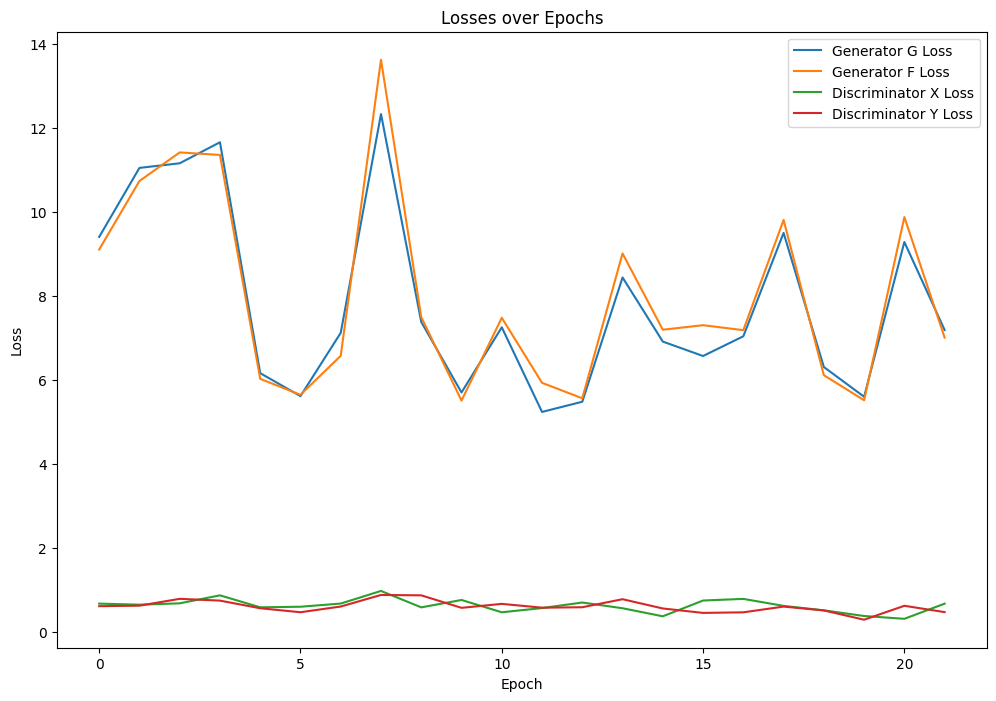

In [38]:
def plot_losses(loss_history):
    plt.figure(figsize=(12, 8))

    plt.plot(loss_history.gen_g_loss, label='Generator G Loss')
    plt.plot(loss_history.gen_f_loss, label='Generator F Loss')
    plt.plot(loss_history.disc_x_loss, label='Discriminator X Loss')
    plt.plot(loss_history.disc_y_loss, label='Discriminator Y Loss')

    plt.title('Losses over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the plot function
plot_losses(loss_history)

## Sample Generated

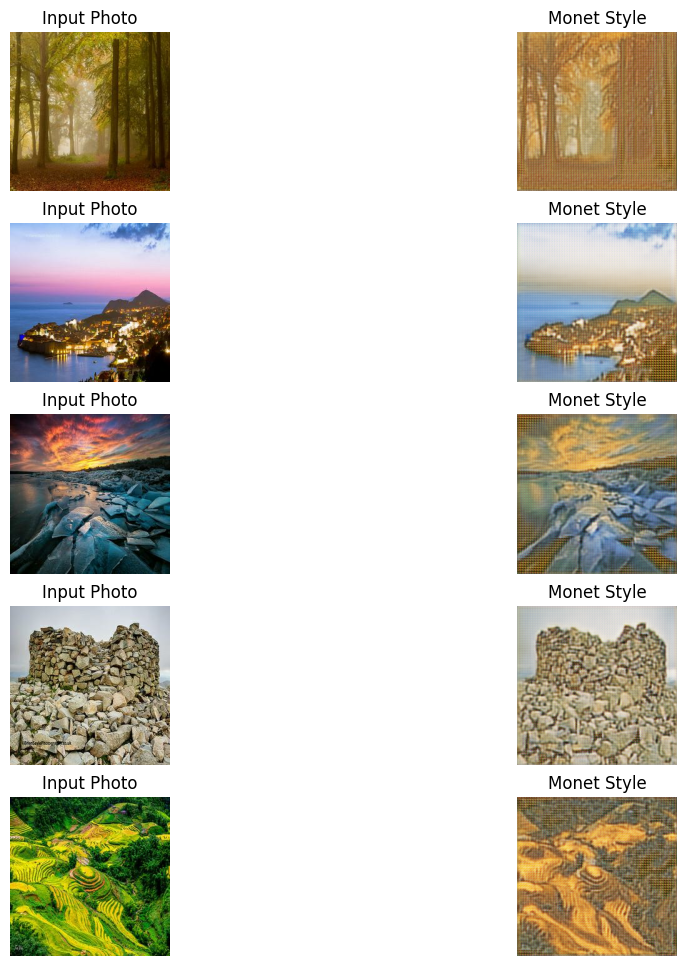

In [39]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = generator_g(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet Style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

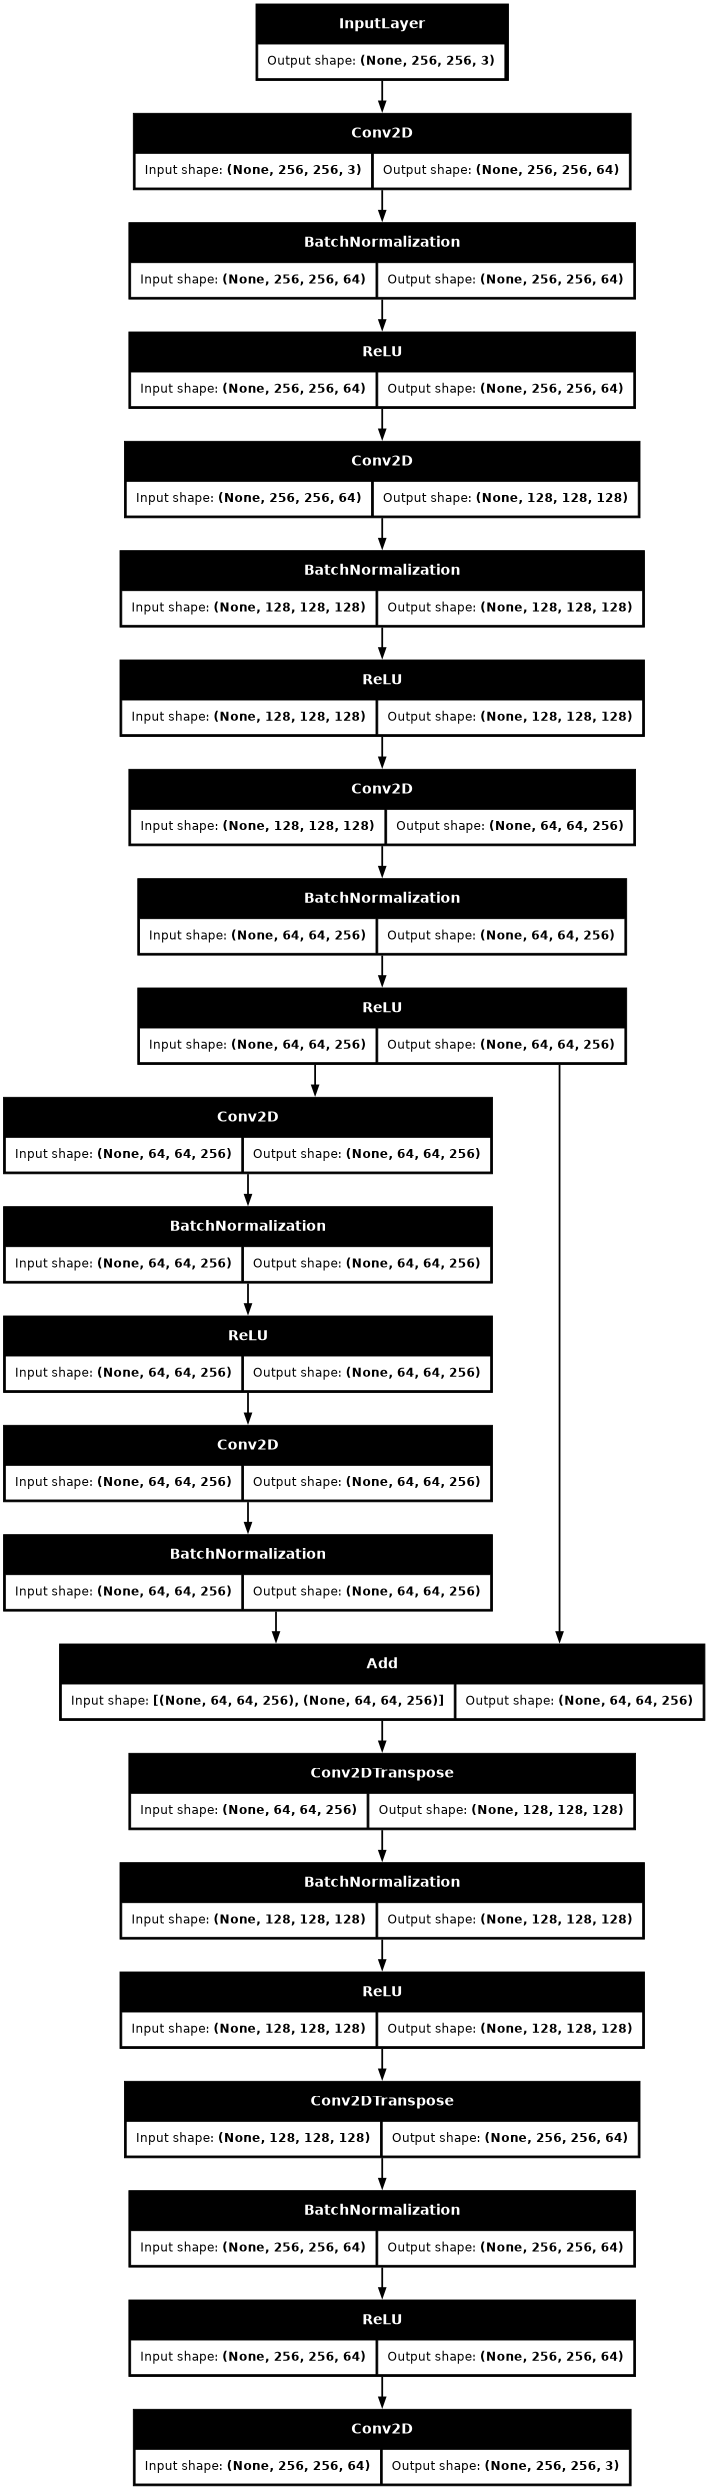

In [27]:
tf.keras.utils.plot_model(generator_f, show_shapes=True, dpi=64)

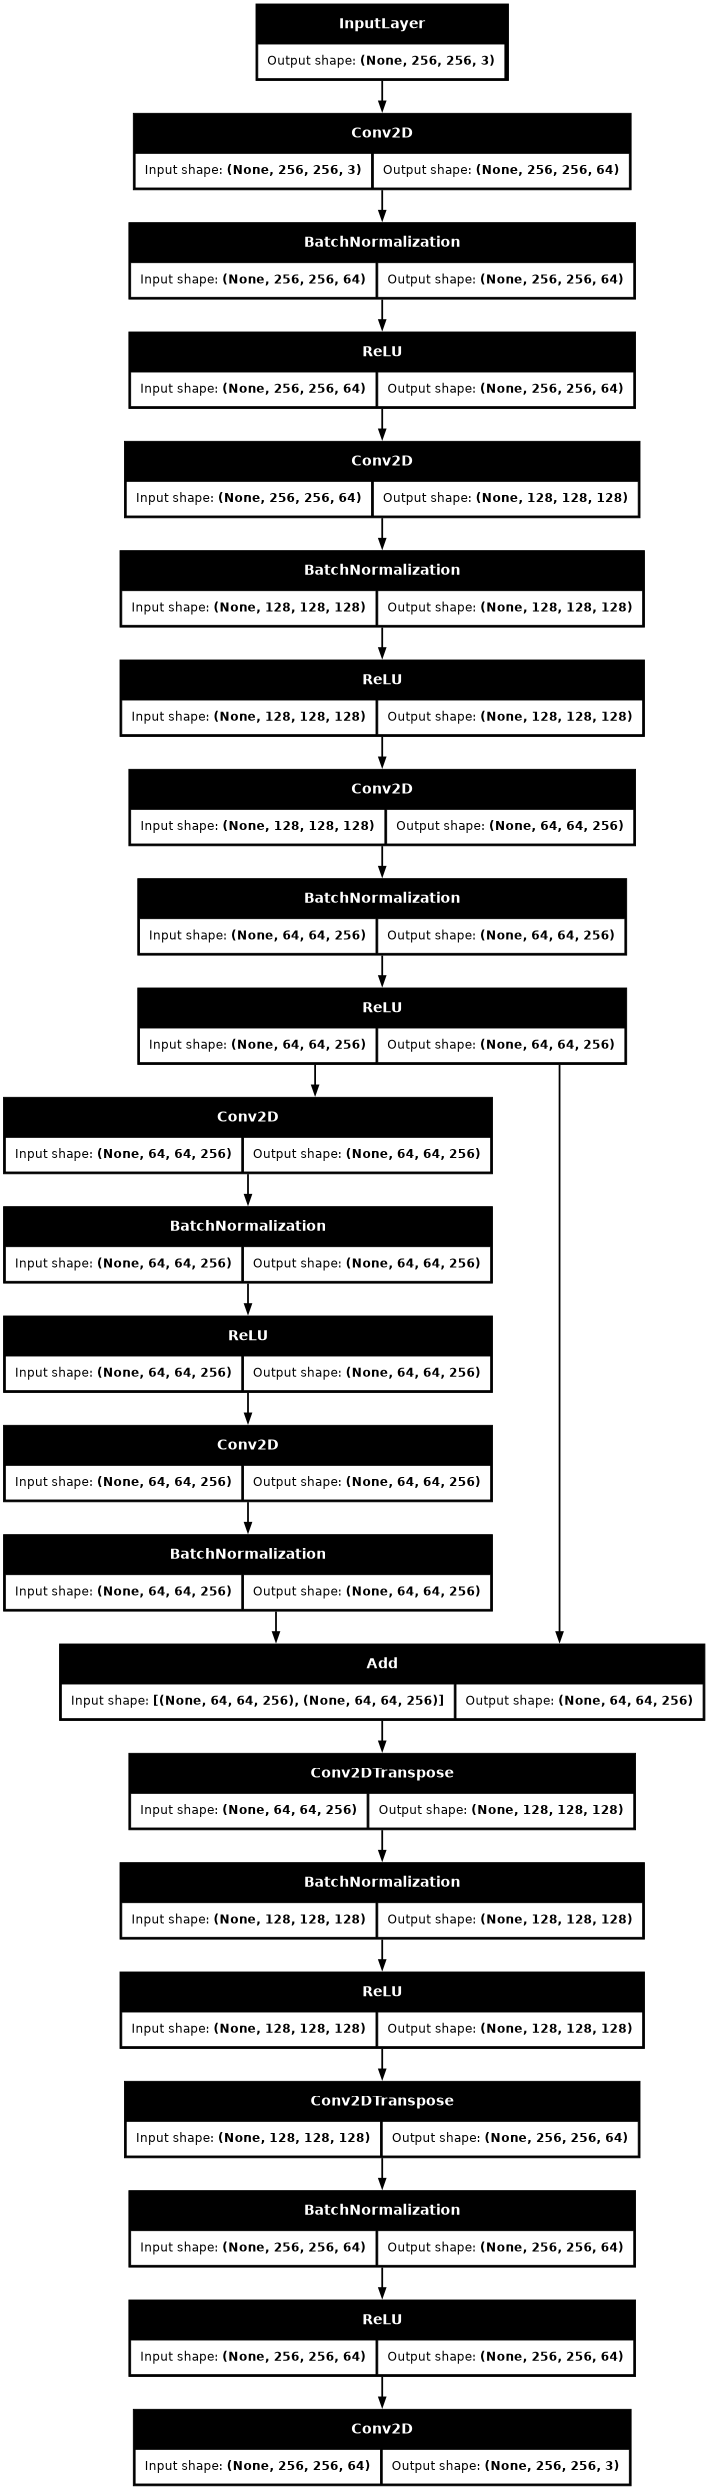

In [28]:
tf.keras.utils.plot_model(generator_g, show_shapes=True, dpi=64)

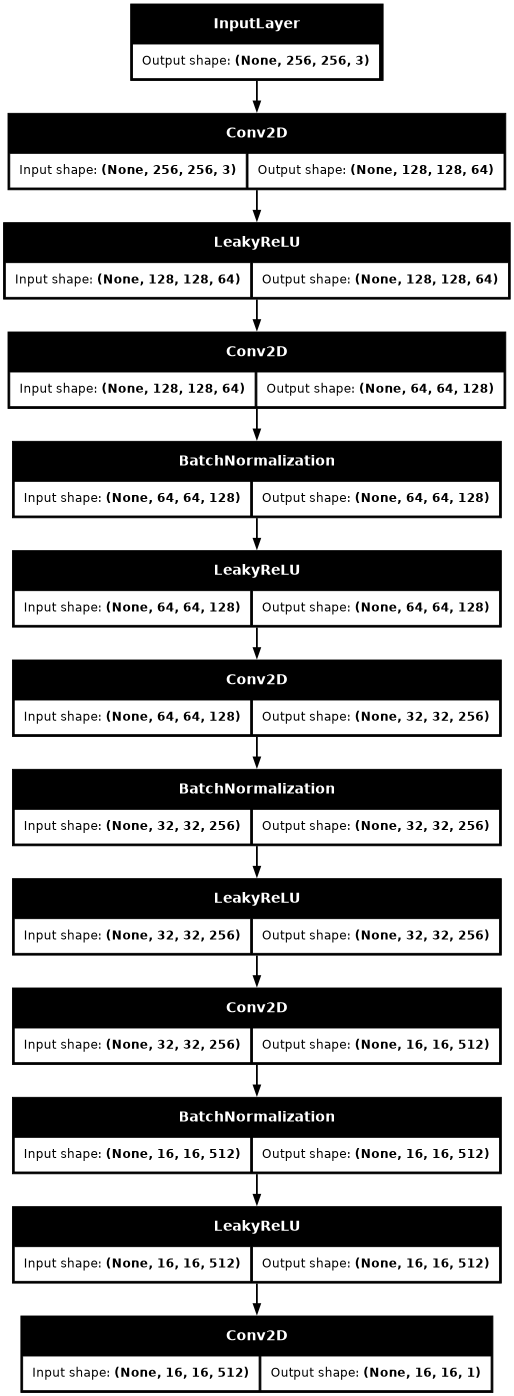

In [29]:
tf.keras.utils.plot_model(discriminator_x, show_shapes=True, dpi=64)

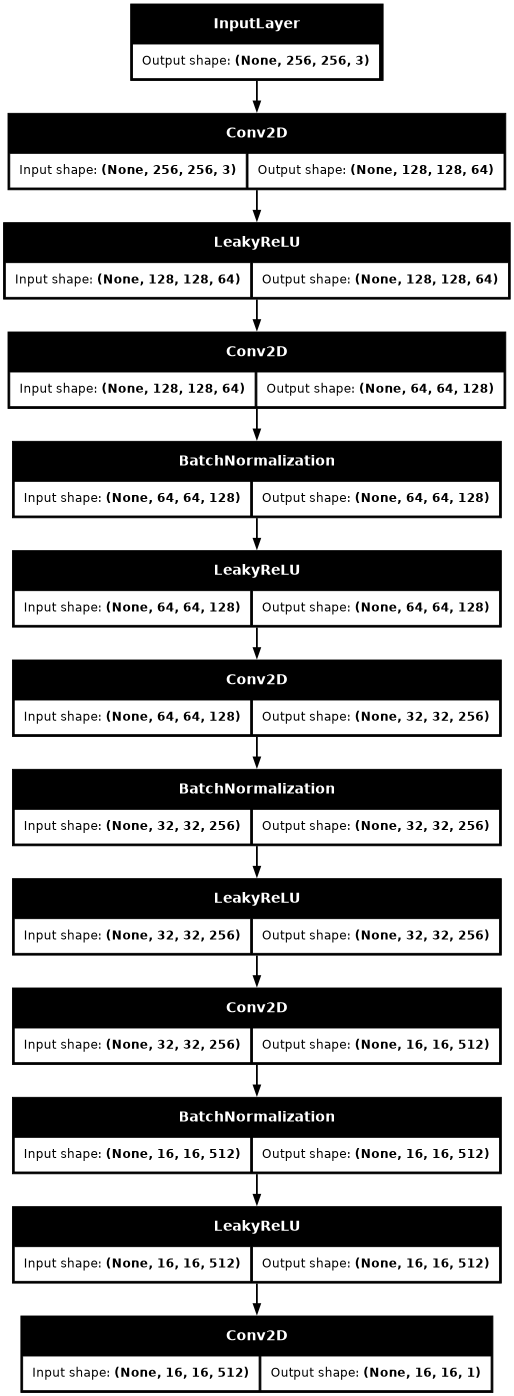

In [30]:
tf.keras.utils.plot_model(discriminator_y, show_shapes=True, dpi=64)

In [42]:
photo_files = tf.io.gfile.glob(f'{INPUT_PHOTO_JPG_DIR}/*.jpg')
def save_final_images_to_zip(model, photo_files, num_images, zip_file_name='images.zip'):
    with ZipFile(zip_file_name, 'w', ZIP_DEFLATED) as zipf:
        for i in range(min(num_images, len(photo_files))):
            # Load and preprocess the image
            test_input = load_and_preprocess_image(photo_files[i])
            test_input = tf.expand_dims(test_input, axis=0)  # Add batch dimension

            # Generate the image
            predictions = model.generator_g(test_input, training=False)

            for j in range(predictions.shape[0]):
                image = tf.image.convert_image_dtype(predictions[j], dtype=tf.uint8)
                image_path = f'final_image_{i}_{j}.jpg'
                encoded_image = tf.io.encode_jpeg(image).numpy()
                zipf.writestr(image_path, encoded_image)
    print(f'{zip_file_name} created successfully.')

# Generate final set of images
save_final_images_to_zip(cycle_gan, photo_files=photo_files, num_images=7000, zip_file_name='images.zip')

images.zip created successfully.


# References
### arxiv Links
- [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/pdf/1701.00160)
- [Generative Adversarial Nets](https://arxiv.org/pdf/1406.2661)
- [UNSUPERVISED REPRESENTATION LEARNING WITH DEEP CONVOLUTIONAL GENERATIVE ADVERSARIAL NETWORKS](https://arxiv.org/pdf/1511.06434)
- [Conditional Generative Adversarial Nets](https://arxiv.org/pdf/1411.1784)
- [Improved Techniques for Training GANs](https://arxiv.org/pdf/1606.03498)
- [U-Net Architecture](https://arxiv.org/abs/1505.04597)
-  [PatchGAN Discriminator](https://arxiv.org/abs/1611.07004)

### Medium Links
- [GAN — GAN Series (from the beginning to the end)](GAN%20%E2%80%94%20GAN%20Series%20%28from%20the%20beginning%20to%20the%20end%29)
- [Vanilla Generative Adversarial Networks](https://bchuan110.medium.com/vanilla-generative-adversarial-networks-4cd90d624197)

### Documentations
- [CycleGAN](https://github.com/junyanz/CycleGAN)
- [Keras - CycleGAN](https://keras.io/examples/generative/cyclegan/)
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Permalink to Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Custom Training Loop](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)
- [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)
- [EarlyStopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)
- [ReduceLROnPlateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau)